<a href="https://colab.research.google.com/github/21-LAKSHMI/AI-AND-ML/blob/main/Silhouette_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
# ---- Step 1: Load data ----
dataset = pd.read_csv("/content/Mall_Customers.csv")

In [3]:
dataset

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [4]:
# Select relevant columns
dataset = dataset[['Gender',	'Age',	'Annual Income (k$)',	'Spending Score (1-100)']]

In [5]:
# Select relevant columns
X = dataset[['Age',  'Annual Income (k$)',   'Spending Score (1-100)']]
scaler = StandardScaler()
X = scaler.fit_transform(X)

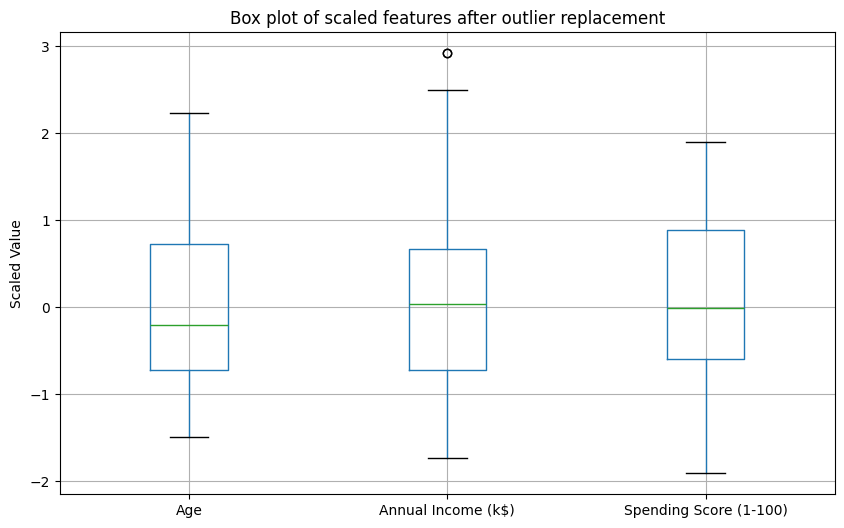

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming X_df was created in a previous step and contains the scaled data
# If X_df is not available, recreate it from X
try:
    X_df
except NameError:
    X_df = pd.DataFrame(X, columns=['Age', 'Annual Income (k$)', 'Spending Score (1-100)'])


# Generate box plots for each feature in the scaled data (including after outlier replacement)
plt.figure(figsize=(10, 6))
X_df.boxplot()
plt.title('Box plot of scaled features after outlier replacement')
plt.ylabel('Scaled Value')
plt.show()

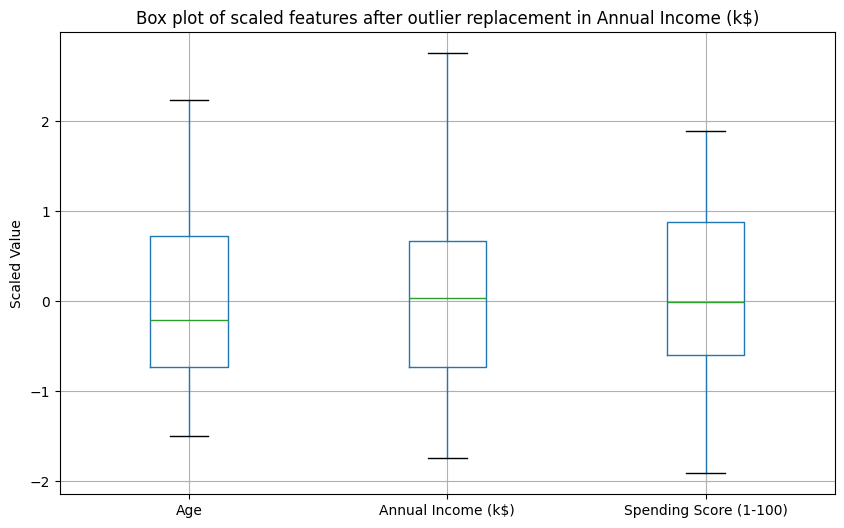

In [7]:
# Calculate IQR for 'Annual Income (k$)'
Q1 = X_df['Annual Income (k$)'].quantile(0.25)
Q3 = X_df['Annual Income (k$)'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Replace outliers in 'Annual Income (k$)' with the upper bound
X_df['Annual Income (k$)'] = X_df['Annual Income (k$)'].apply(lambda x: upper_bound if x > upper_bound else (lower_bound if x < lower_bound else x))

# Display the updated box plot to check the effect of outlier replacement
plt.figure(figsize=(10, 6))
X_df.boxplot()
plt.title('Box plot of scaled features after outlier replacement in Annual Income (k$)')
plt.ylabel('Scaled Value')
plt.show()

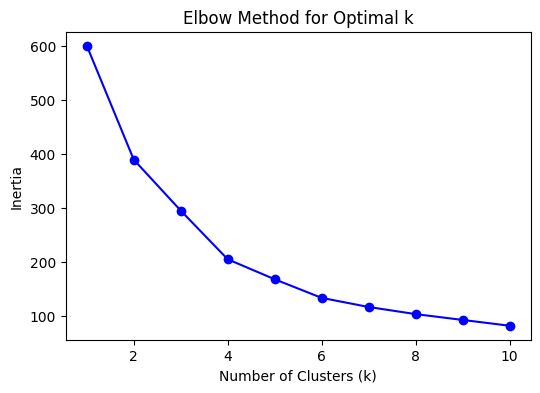

In [8]:
# ---- Step 4: Find optimal number of clusters (Elbow Method) ----
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K, inertia, 'bo-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

In [9]:
# ---- Step 5: Cluster with chosen k (say k=3) ----
chosen_k = 4
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
dataset['Cluster'] = kmeans.fit_predict(X)

In [10]:
# ---- Step 6: Analyze clusters ----
print("\nCluster Means:")
print(dataset.groupby('Cluster')[['Age','Annual Income (k$)','Spending Score (1-100)']].mean())


Cluster Means:
               Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                       
0        53.984615           47.707692               39.969231
1        32.875000           86.100000               81.525000
2        25.438596           40.000000               60.298246
3        39.368421           86.500000               19.578947


In [11]:
# ---- Step 7: Visualize clusters (PCA 2D plot) ----
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

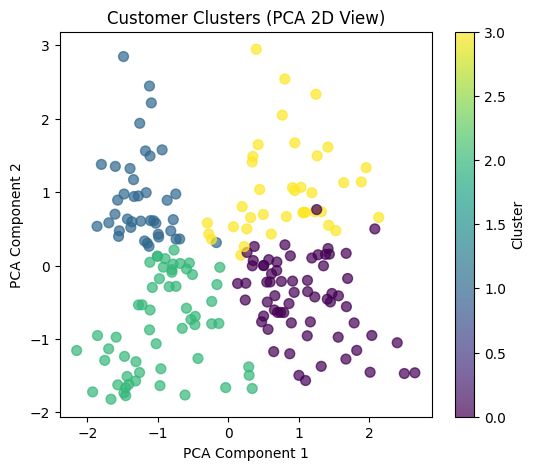

In [12]:
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=dataset['Cluster'], cmap='viridis', s=50, alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Customer Clusters (PCA 2D View)")
plt.colorbar(label="Cluster")
plt.show()


In [13]:
from sklearn.metrics import silhouette_score

# Calculate the average silhouette score for the current clustering
average_silhouette_score = silhouette_score(X, dataset['Cluster'])

print(f"Average Silhouette Score for k={chosen_k}: {average_silhouette_score:.4f}")

Average Silhouette Score for k=4: 0.4040


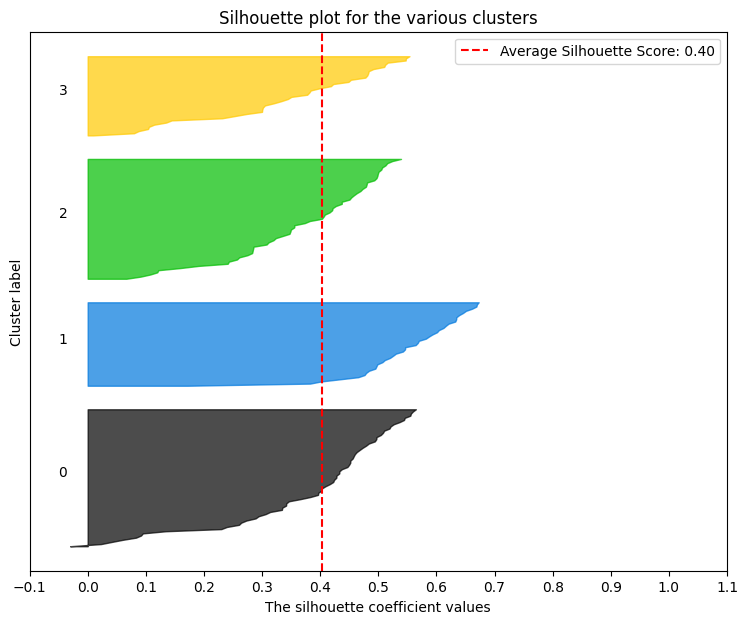

In [14]:
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm
import numpy as np

# Calculate the silhouette scores for each sample
silhouette_per_sample = silhouette_samples(X, dataset['Cluster'])

# Create the silhouette plot
fig, ax1 = plt.subplots(figsize=(9, 7))
y_lower = 10

for i in range(chosen_k):
    # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
    ith_cluster_silhouette_values = \
        silhouette_per_sample[dataset['Cluster'] == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / chosen_k)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10*Space between clusters

ax1.set_title("Silhouette plot for the various clusters")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=average_silhouette_score , color="red", linestyle="--", label=f"Average Silhouette Score: {average_silhouette_score :.2f}")
ax1.set_yticks([])  # Clear the y-axis labels / ticks
ax1.set_xticks(np.arange(-0.1, 1.1, 0.1))
ax1.legend()

plt.show()